In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # data visualisation
import matplotlib.pyplot as plt # plotting

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# load dataset
df = pd.read_csv("/kaggle/input/s-and-p-500-stocks-trade-data-for-first-6-month-2025/sp500_2025_h1.csv")

# select numeric columns only
numeric_df = df.select_dtypes(include='number')

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import pandas as pd 
from sklearn.preprocessing import StandardScaler, LabelEncoder 

class SP500ETLPipeline: 
    def __init__(self, df): 
        self.df = df.copy()
        self.scaler = StandardScaler()
        self.label_encoders = {}

    def reshape_wide_to_long(self):
        """
        Converts wide-format repeated columns (e.g. 02-01-2025_Opening)
        into long format: one row per company per date.
        """
        value_vars = [col for col in self.df.columns if col not in ['company_name', 'ticker']]
        long_df = pd.melt(self.df, id_vars=['company_name', 'ticker'], 
                          value_vars=value_vars,
                          var_name='variable', value_name='value')
        
        # Split column name safely (date first, feature second)
        long_df[['Date', 'Feature']] = long_df['variable'].str.extract(r'([0-9\-]+)_(.*)')
        
        # Pivot to make each Feature a column
        reshaped_df = long_df.pivot_table(index=['company_name', 'ticker', 'Date'], 
                                          columns='Feature', values='value').reset_index()
        
        # Normalize column names (remove spaces, unify casing)
        reshaped_df.columns = [col.strip().replace(' ', '_').lower() for col in reshaped_df.columns]
        
        self.df = reshaped_df


    def encode_categorical(self):
        """
        Label-encode company_name and ticker for ML compatibility.
        """
        for col in ['company_name', 'ticker']: 
            le = LabelEncoder()
            self.df[col] = le.fit_transform(self.df[col])
            self.label_encoders[col] = le

    def scale_features(self, numeric_cols=None):
        """
        Standard-scale numeric columns; if none provided, detect automatically
        """
        if numeric_cols is None: 
            numeric_cols = self.df.select_dtypes(include='number').columns
        self.df[numeric_cols] = self.scaler.fit_transform(self.df[numeric_cols])

    def get_processed_data(self): 
        """
        return the fully transformed dataframe.
        """
        return self.df        

In [3]:
pipeline = SP500ETLPipeline(df)
pipeline.reshape_wide_to_long()
pipeline.encode_categorical()
pipeline.scale_features(['opening', 'volume']) # scale key numeric features
processed_df = pipeline.get_processed_data()
print(processed_df.head(1000))

     company_name  ticker        date  closing   opening    volume
0               0     311  01-04-2025   147.67 -0.150797 -0.166130
1               0     311  01-05-2025   137.90 -0.168418 -0.243891
2               0     311  02-01-2025   129.70 -0.185170 -0.187842
3               0     311  02-04-2025   147.76 -0.151058 -0.123533
4               0     311  02-05-2025   142.08 -0.164920 -0.216337
..            ...     ...         ...      ...       ...       ...
995             8       7  06-01-2025   431.18  0.470101 -0.146595
996             8       7  06-02-2025   435.40  0.482595 -0.225525
997             8       7  06-03-2025   444.78  0.498021 -0.216452
998             8       7  06-05-2025   382.98  0.349917 -0.203280
999             8       7  06-06-2025   416.92  0.438945 -0.248835

[1000 rows x 6 columns]


In [4]:
for col, le in pipeline.label_encoders.items():
    mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    print(f"\nMapping for {col}:")
    display(pd.DataFrame(list(mapping.items()), columns=[col, f"{col}_encoded"]).head())


Mapping for company_name:


,company_name,company_name_encoded
0,3M,0
1,A. O. Smith,1
2,AES Corporation,2
3,APA Corporation,3
4,AT&T,4



Mapping for ticker:


,ticker,ticker_encoded
0,A,0
1,AAPL,1
2,ABBV,2
3,ABNB,3
4,ABT,4


In [5]:
# create DataFrame with original company_name and ticker
original_pairs = df[['company_name', 'ticker']].drop_duplicates().reset_index(drop=True)

# create encoded copies using the same encoders 
encoded_pairs = original_pairs.copy()
encoded_pairs['company_name_encoded'] = pipeline.label_encoders['company_name'].transform(original_pairs['company_name'])
encoded_pairs['ticker_encoded'] = pipeline.label_encoders['ticker'].transform(original_pairs['ticker'])

# combine both into one table for verification
verification_df = encoded_pairs[['company_name', 'ticker', 'company_name_encoded', 'ticker_encoded']]
filtered_df = verification_df[(verification_df['company_name'] == '3M') | (verification_df['company_name_encoded'] == 8)]

print("Verification table - original vs encoded values:")
display(filtered_df.head()) 
print(f"\nTotal verified entries: {len(filtered_df)}")

Verification table - original vs encoded values:


,company_name,ticker,company_name_encoded,ticker_encoded
80,Adobe Inc.,ADBE,8,7
132,3M,MMM,0,311



Total verified entries: 2


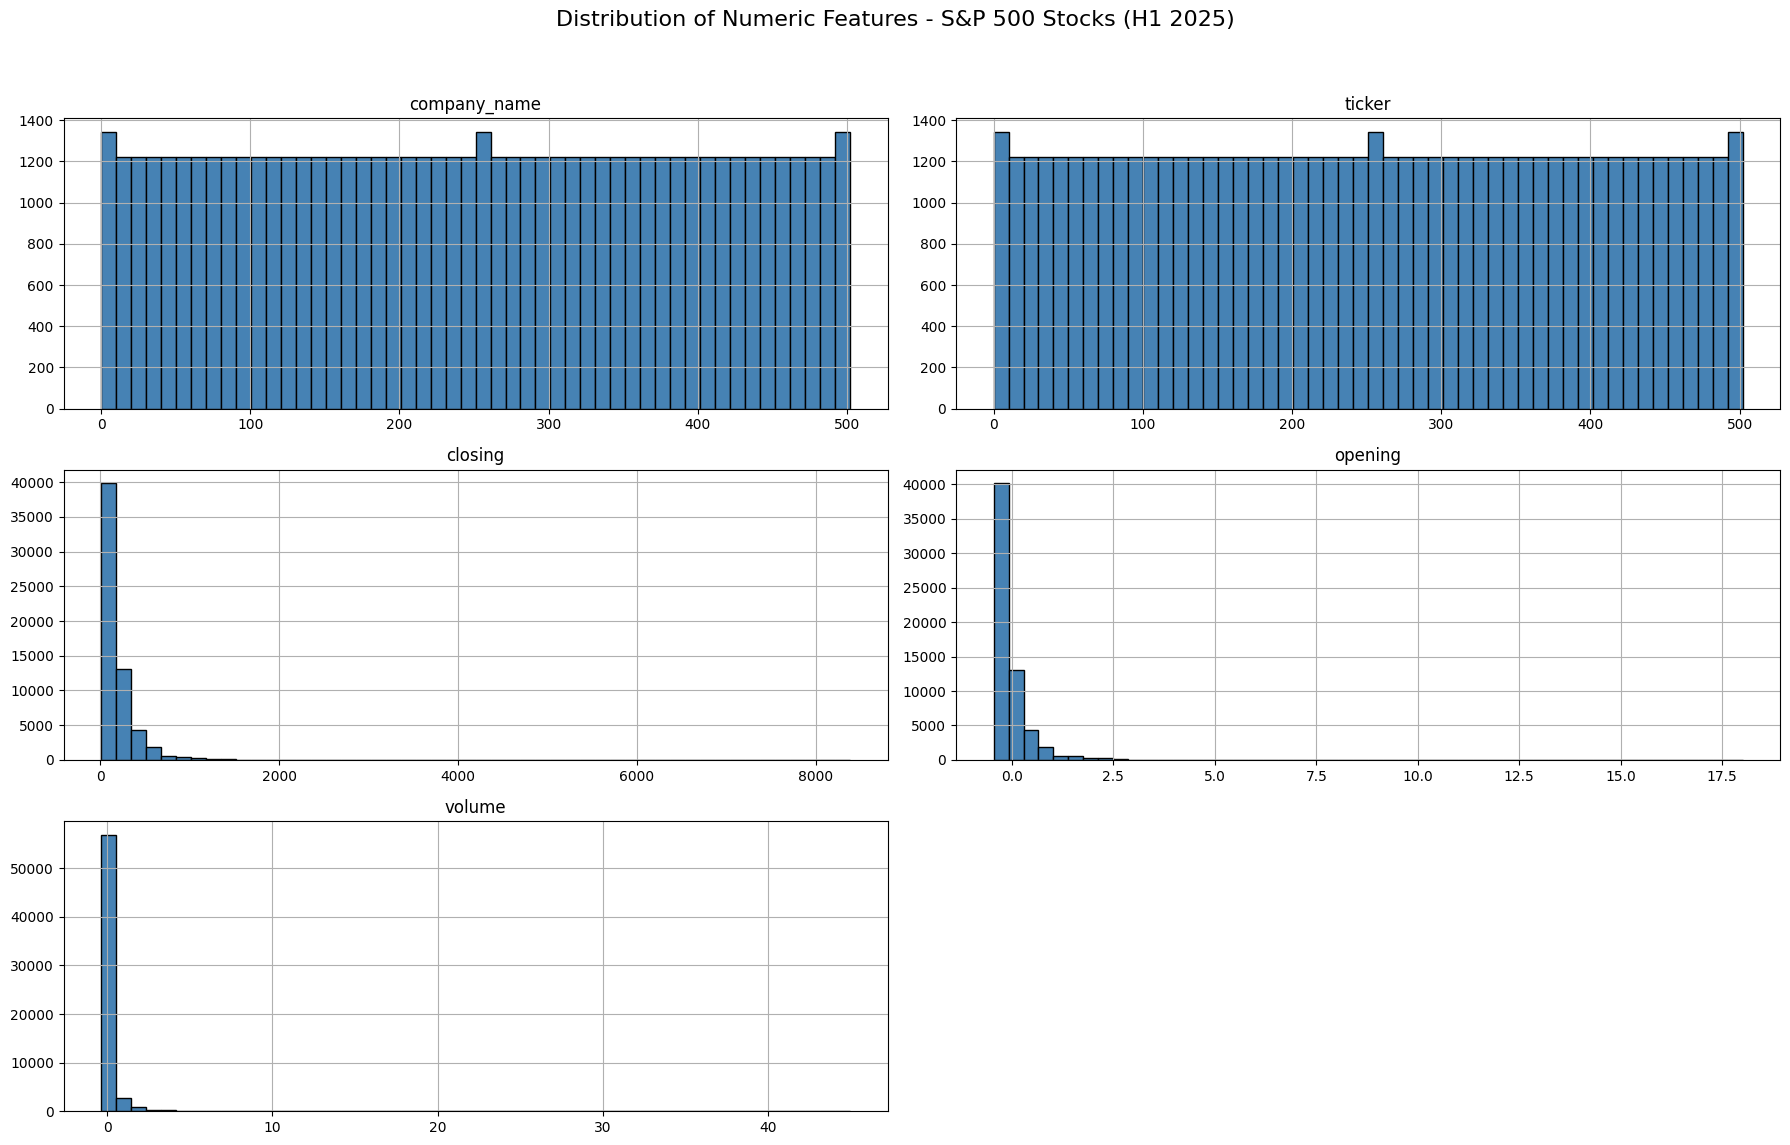

In [6]:
import matplotlib.pyplot as plt

# select numeric columns only 
numeric_cols = processed_df.select_dtypes(include='number')

# plot histograms 
numeric_cols.hist(
    bins=50, 
    figsize=(18, 12), 
    color='steelblue',
    edgecolor='black'
)

plt.suptitle("Distribution of Numeric Features - S&P 500 Stocks (H1 2025)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("distribution_hist.png")
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


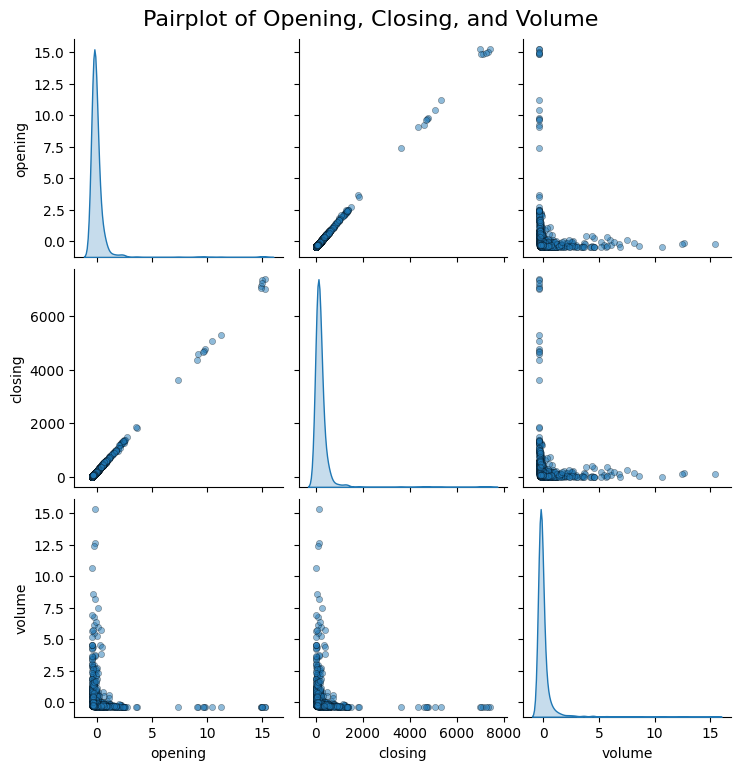

In [7]:
import seaborn as sns 

# select a subset of numeric features to keep plots readable 
subset_cols = ['opening', 'closing', 'volume']

# optional: sample rows if dataset is large
sampled_df = processed_df[subset_cols].sample(2000, random_state=42)

# create pairplot
sns.pairplot(sampled_df, diag_kind='kde', plot_kws={'alpha':0.5, 's':20, 'edgecolor':'k'})
plt.suptitle("Pairplot of Opening, Closing, and Volume", fontsize=16, y=1.02)
plt.savefig("pairplot.png")
plt.show()

In [8]:
from sklearn.model_selection import train_test_split 

# featrues (X) and target (y)
# we'll predict 'closing', using 'company_name', 'ticker', 'opening', 'volume'
X = processed_df[['company_name', 'ticker', 'opening', 'volume']]
y = processed_df['closing']

# split into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# check shapes
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

X_train: (49092, 4)
X_test: (12274, 4)
y_train: (49092,)
y_test: (12274,)
